# Full IV curve with different starting point options

# using pulse_one into read_one

Discovering devices...
Using device ID: 0

Available Sweep Types:
1. Full (0 → max → 0 → min → 0) - Complete memristor characterization
2. Hysteresis (min → max → min) - Standard hysteresis
3. Bipolar (min → 0 → max → 0 → min) - Full bipolar cycle

--- Starting Enhanced IV Sweep ---
Opening instrument...
Instrument opened successfully

--- Detailed Device Channel Diagnostics ---
Resetting all channels to ground...

Testing voltage read capabilities:
Voltage readings: [0.002890625037252903, -0.0022656249348074198]

Testing basic pulse operation:
Read current after pulse: -5.735511513194069e-05

Verifying channel configuration:
Channels configured successfully

--- Starting IV Sweep Measurement ---
Starting sweep using full pattern with 84 points

Point 1/84: V=0.000 V
V=0.000V, I=-5.748e-05A, R=-0.00e+00Ω

Point 2/84: V=0.100 V
V=0.100V, I=-5.831e-05A, R=-1.71e+03Ω

Point 3/84: V=0.200 V
V=0.200V, I=-5.718e-05A, R=-3.50e+03Ω

Point 4/84: V=0.300 V
V=0.300V, I=-5.813e-05A, R=-5.16e+03Ω



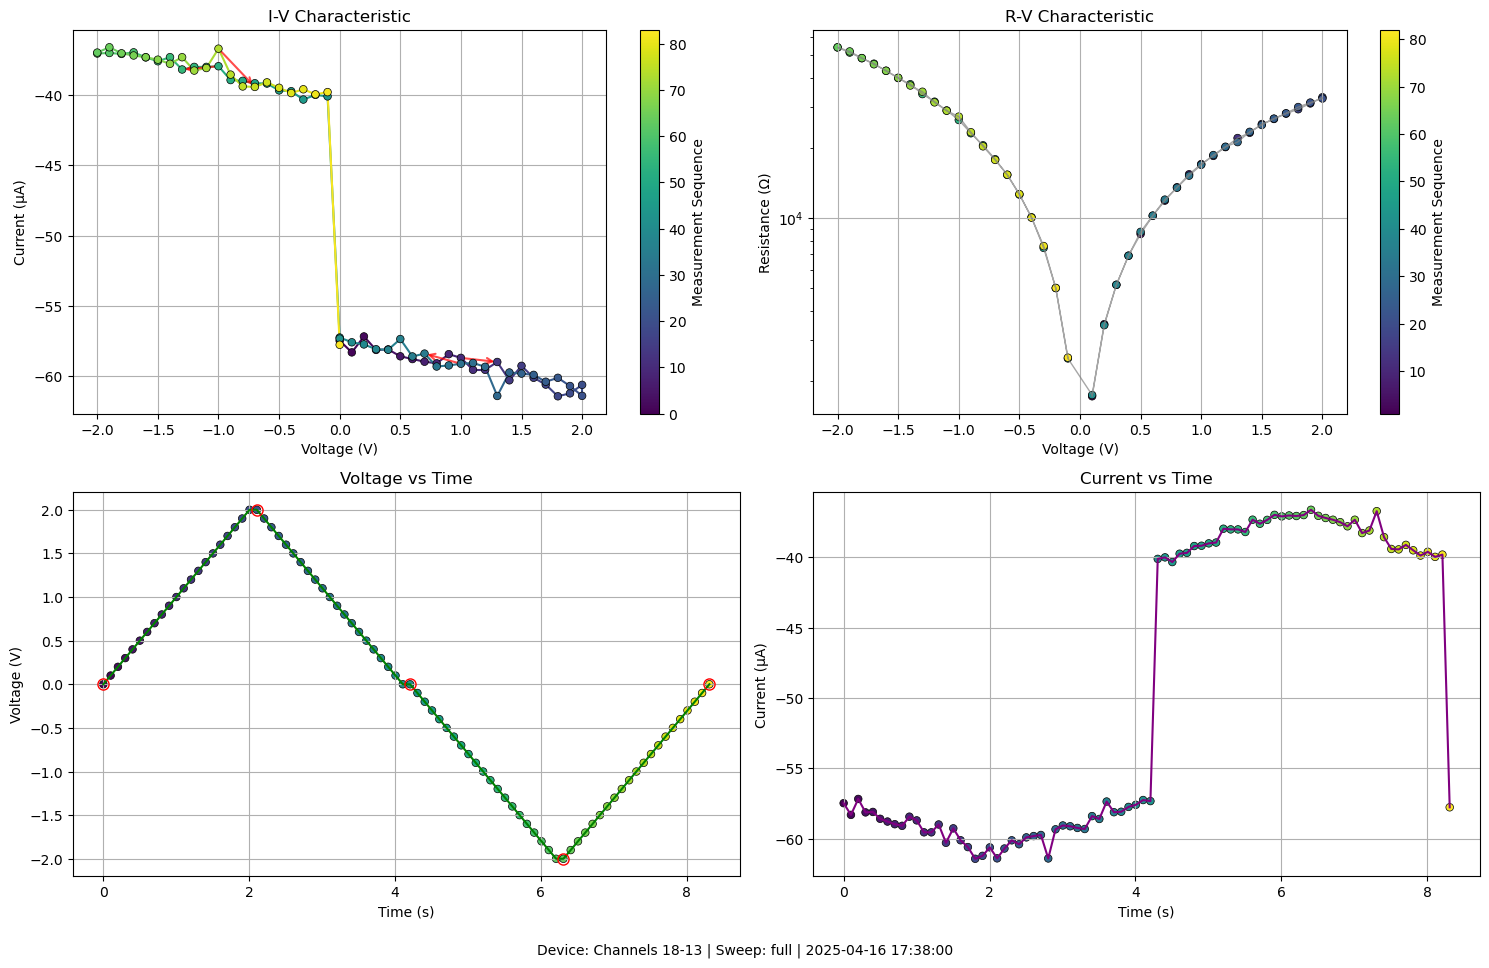

Data exported to /scratch/renj/ArcTwo Code/iv_meas_full_ch18-13_20250416_173808.h5


In [1]:
from pyarc2 import Instrument, find_ids, DataMode, ReadType
import numpy as np
import matplotlib.pyplot as plt
import traceback
import time
from datetime import datetime
import h5py
import os

def detailed_device_check(arc2, low_chan, high_chan):
    """
    Perform a detailed diagnostic check on the device channels
    """
    print("\n--- Detailed Device Channel Diagnostics ---")
    
    try:
        # Reset all channels
        print("Resetting all channels to ground...")
        arc2.ground_all().execute()
        
        # Check basic voltage reading
        print("\nTesting voltage read capabilities:")
        try:
            # Try reading voltage on the specified channels
            voltage_readings = arc2.vread_channels([low_chan, high_chan], averaging=True)
            print(f"Voltage readings: {voltage_readings}")
        except Exception as e:
            print(f"Error reading voltages: {e}")
        
        # Try a simple pulse
        print("\nTesting basic pulse operation:")
        try:
            # Apply a small pulse and read
            arc2.pulse_one(low_chan, high_chan, 0.5, 1000).execute()
            
            # Attempt to read current
            try:
                current = arc2.read_one(low_chan, high_chan, 0.2)
                print(f"Read current after pulse: {current}")
            except Exception as curr_err:
                print(f"Error reading current: {curr_err}")
        except Exception as pulse_err:
            print(f"Error applying pulse: {pulse_err}")
        
        # Verify channel configuration
        print("\nVerifying channel configuration:")
        try:
            # Configure channels to arbitrary voltage mode
            arc2.config_channels([(low_chan, 0.1), (high_chan, 0.1)], None).execute()
            print("Channels configured successfully")
        except Exception as config_err:
            print(f"Error configuring channels: {config_err}")
    
    except Exception as e:
        print(f"Unexpected error in device check: {e}")

def memristor_iv_sweep(device_id, firmware_path, low_chan, high_chan, voltage_range=(-2.0, 2.0), steps=21, 
                   sweep_type='full', reset_voltage=None, compliance_current=1e-3, debug=False):
    """
    Perform a comprehensive IV sweep with proper memristor characterization
    
    Parameters:
    -----------
    device_id : int
        ArC TWO device ID
    firmware_path : str
        Path to firmware file
    low_chan : int
        Low potential channel
    high_chan : int
        High potential channel
    voltage_range : tuple
        (min_voltage, max_voltage)
    steps : int
        Number of voltage steps in one direction
    sweep_type : str
        Type of sweep pattern: 
        - 'full': 0 → max → 0 → min → 0 (complete memristor characterization)
        - 'hysteresis': min → max → min (standard hysteresis)
        - 'set-reset': 0 → max(SET) → 0 → min(RESET) → 0
        - 'bipolar': min → 0 → max → 0 → min
    reset_voltage : float or None
        Optional voltage to reset the device state before starting sweep
    debug : bool
        Enable verbose debug output
    
    Returns:
    --------
    dict
        Dictionary containing measurement results
    """
    print("\n--- Starting Enhanced IV Sweep ---")
    
    # Open instrument
    try:
        print("Opening instrument...")
        arc2 = Instrument(device_id, firmware_path)
        print("Instrument opened successfully")
    except Exception as e:
        print(f"Error opening instrument: {e}")
        print(traceback.format_exc())
        return None

    # Run detailed check if in debug mode
    if debug:
        detailed_device_check(arc2, low_chan, high_chan)

    # Create voltage sweep based on specified pattern
    min_v, max_v = voltage_range
    
    if sweep_type == 'full':
        # Full characterization cycle: 0 → max → 0 → min → 0
        v_0_to_max = np.linspace(0, max_v, steps)
        v_max_to_0 = np.linspace(max_v, 0, steps)
        v_0_to_min = np.linspace(0, min_v, steps)
        v_min_to_0 = np.linspace(min_v, 0, steps)
        voltages = np.concatenate((v_0_to_max, v_max_to_0, v_0_to_min, v_min_to_0))
        
    elif sweep_type == 'hysteresis':
        # Traditional hysteresis loop: min → max → min
        v_up = np.linspace(min_v, max_v, steps)
        v_down = np.linspace(max_v, min_v, steps)
        voltages = np.concatenate((v_up, v_down))
        
    # elif sweep_type == 'set-reset':
    #     # SET-RESET cycle for bipolar switching: 0 → max(SET) → 0 → min(RESET) → 0
    #     v_0_to_max = np.linspace(0, max_v, steps)
    #     v_max_to_0 = np.linspace(max_v, 0, steps)
    #     v_0_to_min = np.linspace(0, min_v, steps)
    #     v_min_to_0 = np.linspace(min_v, 0, steps)
    #     voltages = np.concatenate((v_0_to_max, v_max_to_0, v_0_to_min, v_min_to_0))
        
    elif sweep_type == 'bipolar':
        # Bipolar sweep: min → 0 → max → 0 → min
        v_min_to_0 = np.linspace(min_v, 0, steps//2)
        v_0_to_max = np.linspace(0, max_v, steps//2)
        v_max_to_0 = np.linspace(max_v, 0, steps//2)
        v_0_to_min = np.linspace(0, min_v, steps//2)
        voltages = np.concatenate((v_min_to_0, v_0_to_max, v_max_to_0, v_0_to_min))
    
    else:
        print(f"Unknown sweep type '{sweep_type}'. Using default hysteresis pattern.")
        v_0_to_max = np.linspace(0, max_v, steps)
        v_max_to_0 = np.linspace(max_v, 0, steps)
        v_0_to_min = np.linspace(0, min_v, steps)
        v_min_to_0 = np.linspace(min_v, 0, steps)
        voltages = np.concatenate((v_0_to_max, v_max_to_0, v_0_to_min, v_min_to_0))
    
    # Result containers
    currents = []
    resistances = []
    timestamps = []
    
    try:
        # Reset and ground
        print("\n--- Starting IV Sweep Measurement ---")
        arc2.ground_all().execute()
        
        # Apply reset voltage if specified (for consistent initial state)
        if reset_voltage is not None:
            print(f"Applying reset voltage: {reset_voltage} V")
            try:
                if reset_voltage >= 0:
                    arc2.pulse_one(low_chan, high_chan, reset_voltage, 100000).execute()  # 100ms pulse
                else:
                    arc2.pulse_one(high_chan, low_chan, abs(reset_voltage), 100000).execute()
                # Wait for stabilization
                time.sleep(0.1)
                arc2.ground_all().execute()
                time.sleep(0.1)
            except Exception as reset_error:
                print(f"Error applying reset voltage: {reset_error}")
        
        # Important: For memristive devices, DO NOT ground between measurements
        # to preserve state history through the voltage sequence
        print(f"Starting sweep using {sweep_type} pattern with {len(voltages)} points")
        
        # Initial grounding before sequence begins
        arc2.ground_all().execute()
        time.sleep(0.1)
        
        # Sweep through voltages without intermediate grounding
        for i, v in enumerate(voltages):
            start_time = time.time()
            try:
                if debug:
                    print(f"\nPoint {i+1}/{len(voltages)}: V={v:.3f} V")
                
                # Directly read current at this voltage without grounding first
                if v >= 0:
                    current = arc2.read_one(low_chan, high_chan, v)
                else:
                    current = -arc2.read_one(high_chan, low_chan, abs(v))

                # Compliance check
                if abs(current) > compliance_current:
                    print(f"Compliance current exceeded ({abs(current):.3e} A > {compliance_current:.3e} A). Stopping sweep.")
                    break  # Stop the sweep if compliance is exceeded
                
                # Calculate resistance
                resistance = v / current if abs(current) > 1e-12 else float('inf')
                
                # Store results
                currents.append(current)
                resistances.append(resistance)
                timestamps.append(time.time())
                
                if debug:
                    print(f"V={v:.3f}V, I={current:.3e}A, R={resistance:.2e}Ω")
                
            except Exception as point_error:
                print(f"Error at voltage point {v}: {point_error}")
                currents.append(np.nan)
                resistances.append(np.nan)
                timestamps.append(time.time())
            
            # Add a small delay between measurements
            measurement_time = time.time() - start_time
            if measurement_time < 0.1:  # Ensure at least 100ms between points
                time.sleep(0.1 - measurement_time)
        
    except Exception as e:
        print(f"Unexpected error during IV sweep: {e}")
        print(traceback.format_exc())
        return None
    
    finally:
        # Ensure device is grounded after measurement
        try:
            arc2.ground_all().execute()
            print("Device grounded after measurement")
        except Exception as ground_error:
            print(f"Error grounding device: {ground_error}")
    
    # Prepare results dictionary
    results = {
        'voltage': voltages,
        'current': np.array(currents),
        'resistance': np.array(resistances),
        'timestamp': np.array(timestamps),
        'low_chan': int(low_chan),
        'high_chan': int(high_chan),
        'sweep_type': sweep_type,
        'voltage_range': voltage_range,
        'measurement_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    return results

def plot_iv_curves(results, save_plot=False):
    """
    Plot comprehensive I-V curve analysis with multiple perspectives
    
    Parameters:
    -----------
    results : dict
        Dictionary containing measurement results
    save_plot : bool
        Whether to save the plot to file
    """
    if results is None:
        print("No valid data to plot")
        return
    
    try:
        # Create figure with subplots
        fig = plt.figure(figsize=(15, 10))
        
        # 1. I-V Characteristic curve
        ax1 = fig.add_subplot(2, 2, 1)
        
        # Use color gradient to show measurement sequence
        voltage = results['voltage']
        current = np.array(results['current']) * 1e6  # Convert to μA
        n_points = len(voltage)
        
        # Create a color gradient to show the sequence
        colors = plt.cm.viridis(np.linspace(0, 1, n_points))
        
        # Plot points with color gradient and connect with lines
        for i in range(n_points-1):
            ax1.plot(voltage[i:i+2], current[i:i+2], '-', color=colors[i], linewidth=1.5)
        
        # Plot scatter points on top
        scatter = ax1.scatter(voltage, current, c=np.arange(n_points), cmap='viridis', 
                              s=30, zorder=10, edgecolor='black', linewidth=0.5)
        
        # Add colorbar to show sequence direction
        cbar = plt.colorbar(scatter, ax=ax1)
        cbar.set_label('Measurement Sequence')
        
        # Add arrows to show sweep direction at key points
        arrow_indices = []
        # Choose arrow positions based on sweep type
        if 'sweep_type' in results and results['sweep_type'] == 'full':
            # For the full cycle, place arrows at key transitions
            steps_per_segment = n_points // 4
            arrow_indices = [steps_per_segment//2, steps_per_segment+steps_per_segment//2, 
                            2*steps_per_segment+steps_per_segment//2, 3*steps_per_segment+steps_per_segment//2]
        else:
            # Default approach for other sweep types
            arrow_indices = [int(n_points/8), int(3*n_points/8), int(5*n_points/8), int(7*n_points/8)]
        
        for i in arrow_indices:
            if i+3 < n_points:
                ax1.annotate('',
                            xy=(voltage[i+3], current[i+3]),
                            xytext=(voltage[i], current[i]),
                            arrowprops=dict(arrowstyle='->', lw=1.5, color='red', alpha=0.7))
        
        ax1.set_xlabel('Voltage (V)')
        ax1.set_ylabel('Current (μA)')
        ax1.set_title('I-V Characteristic')
        ax1.grid(True)
        
        # 2. R-V Characteristic curve (log scale)
        ax2 = fig.add_subplot(2, 2, 2)
        resistance_data = np.array(results['resistance'])
        # Convert to absolute values before filtering
        abs_resistance = np.abs(resistance_data)
        # Filter out non-finite or very large values
        valid_indices = np.isfinite(abs_resistance) & (abs_resistance > 0) & (abs_resistance < 1e9)

        if np.any(valid_indices):
            scatter_r = ax2.scatter(
                np.array(voltage)[valid_indices],
                abs_resistance[valid_indices],  # Already absolute values
                c=np.arange(n_points)[valid_indices],
                cmap='viridis',
                s=30,
                edgecolor='black',
                linewidth=0.5
            )
            
            # Connect points with lines
            ax2.semilogy(
                np.array(voltage)[valid_indices],
                abs_resistance[valid_indices],  # Already absolute values
                '-',
                linewidth=1,
                alpha=0.7,
                color='gray'
            )
            # Add colorbar
            cbar_r = plt.colorbar(scatter_r, ax=ax2)
            cbar_r.set_label('Measurement Sequence')
            
        ax2.set_xlabel('Voltage (V)')
        ax2.set_ylabel('Resistance (Ω)')
        ax2.set_title('R-V Characteristic')
        ax2.grid(True)
        
        # Create relative time axis in seconds
        time_values = np.array(results['timestamp']) - results['timestamp'][0]
        
        # 3. Voltage vs Time plot
        ax3 = fig.add_subplot(2, 2, 3)
        ax3.plot(time_values, voltage, '-', linewidth=1.5, color='green')
        ax3.scatter(time_values, voltage, c=np.arange(n_points), cmap='viridis', 
                   s=30, edgecolor='black', linewidth=0.5)
        
        # Mark important transitions in the voltage pattern
        if 'sweep_type' in results:
            sweep_type = results['sweep_type']
            if sweep_type == 'full' or sweep_type == 'set-reset':
                # Mark the 0→max→0→min→0 transitions
                segments = n_points // 4
                transition_points = [0, segments, 2*segments, 3*segments, n_points-1]
                for idx in transition_points:
                    ax3.plot(time_values[idx], voltage[idx], 'ro', markersize=8, fillstyle='none')
        
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Voltage (V)')
        ax3.set_title('Voltage vs Time')
        ax3.grid(True)
        
        # 4. Current vs Time plot
        ax4 = fig.add_subplot(2, 2, 4)
        ax4.plot(time_values, current, '-', linewidth=1.5, color='purple')
        scatter_i = ax4.scatter(time_values, current, c=np.arange(n_points), cmap='viridis', 
                              s=30, edgecolor='black', linewidth=0.5)
        
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Current (μA)')
        ax4.set_title('Current vs Time')
        ax4.grid(True)
        
        # Add metadata as text annotation
        plt.figtext(0.5, 0.01, 
                  f"Device: Channels {results['low_chan']}-{results['high_chan']} | " +
                  f"Sweep: {results.get('sweep_type', 'standard')} | " +
                  f"{results['measurement_time']}", 
                  ha='center', fontsize=10)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        
        if save_plot:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f'iv_curve_analysis_{timestamp}.png'
            plt.savefig(filename, dpi=300)
            print(f"Plot saved to {filename}")
        
        plt.show()
        
    except Exception as e:
        print(f"Error plotting characteristics: {e}")
        print(traceback.format_exc())

def export_data_h5(results, filename=None, export_path=None, compression="gzip"):
    """
    Export measurement data to HDF5 (H5) file.
    Stores primary data arrays as datasets and scalar metadata as attributes.
    """
    if results is None:
        print("No data to export")
        return

    try:
        # Generate filename if not provided
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            sweep_type = results.get('sweep_type', 'sweep')
            low_ch = results.get('low_chan', 'L')
            high_ch = results.get('high_chan', 'H')
            filename = f'iv_meas_{sweep_type}_ch{low_ch}-{high_ch}_{timestamp}.h5'

        # Determine export path
        if export_path is None:
            export_path = os.getcwd()  # Use current working directory if not specified

        # Create directory if it doesn't exist
        os.makedirs(export_path, exist_ok=True)

        # Create full file path
        full_path = os.path.join(export_path, filename)

        # Create H5 file
        with h5py.File(full_path, 'w') as hf:
            # --- Store Primary Data Arrays as Datasets ---
            compression_opts = compression if compression else None

            if 'voltage' in results and results['voltage'] is not None:
                 hf.create_dataset('voltage', data=results['voltage'], compression=compression_opts)
            if 'current' in results and results['current'] is not None:
                 hf.create_dataset('current', data=results['current'], compression=compression_opts)
            if 'resistance' in results and results['resistance'] is not None:
                 hf.create_dataset('resistance', data=results['resistance'], compression=compression_opts)
            if 'timestamp' in results and results['timestamp'] is not None:
                 # Store relative time in seconds
                 hf.create_dataset('timestamp_relative_s', data=results['timestamp'] - results['timestamp'][0], compression=compression_opts)

            # --- Store Scalar Metadata as Attributes ---
            metadata_to_store = {}
            for k, v in results.items():
                # Include items that are not numpy arrays (or specific arrays like voltage_range)
                if not isinstance(v, np.ndarray) or k in ['voltage_range']:
                     metadata_to_store[k] = v

            # Add metadata as attributes to the root group
            for k, v in metadata_to_store.items():
                try:
                    # Attempt to store directly
                    hf.attrs[k] = v
                except TypeError:
                    # If direct storage fails (e.g., for tuples or complex objects), store as string
                    hf.attrs[k] = str(v) # Fallback to string representation

            # Optionally add the source script name
            hf.attrs['source_script'] = 'newIV.ipynb'


        print(f"Data exported to {full_path}")

    except Exception as e:
        print(f"Error exporting data: {e}")
        print(traceback.format_exc())

def main():
    try:
        # Find available devices
        print("Discovering devices...")
        ids = find_ids()
        
        if len(ids) == 0:
            print('No ArC2 devices found')
            return
        
        # Device configuration (adjust as needed)
        device_id = ids[0]
        firmware_path = '/home/abaigol/.local/share/arc2control/firmware/efm03_20240918.bin'
        low_chan = 18   # Update with your device channels
        high_chan = 13
        
        print(f"Using device ID: {device_id}")
        
        # Provide a menu of available sweep types
        print("\nAvailable Sweep Types:")
        print("1. Full (0 → max → 0 → min → 0) - Complete memristor characterization")
        print("2. Hysteresis (min → max → min) - Standard hysteresis")
        # print("3. SET-RESET (0 → max → 0 → min → 0) - Bipolar switching pattern")
        print("3. Bipolar (min → 0 → max → 0 → min) - Full bipolar cycle")
        
        sweep_choice = input("Choose sweep type (1-3) [default=1]: ")
        
        sweep_type_map = {
            '1': 'full',
            '2': 'hysteresis',
            '3': 'bipolar'
        }
        
        sweep_type = sweep_type_map.get(sweep_choice.strip(), 'full')
        
        # Ask for voltage range
        try:
            min_v = float(input(f"Enter minimum voltage (V) [default=-2.0]: ") or "-2.0")
            max_v = float(input(f"Enter maximum voltage (V) [default=2.0]: ") or "2.0")
            steps = int(input(f"Enter number of steps per segment [default=21]: ") or "21")
        except ValueError:
            print("Invalid input. Using default values.")
            min_v, max_v, steps = -2.0, 2.0, 21
            
        # Ask about reset pulse
        try:
            reset_choice = input("Apply reset pulse before measurement? (y/n) [default=n]: ").strip().lower()
            if reset_choice == 'y':
                reset_v = float(input("Enter reset voltage (V): "))
            else:
                reset_v = None
        except ValueError:
            print("Invalid input. No reset pulse will be applied.")
            reset_v = None
        
        # Perform enhanced IV sweep
        results = memristor_iv_sweep(
            device_id, 
            firmware_path, 
            low_chan, 
            high_chan,
            voltage_range=(min_v, max_v),
            steps=steps,
            sweep_type=sweep_type,
            reset_voltage=reset_v,
            debug=True
        )
        
        # Plot and export results
        if results is not None:
            plot_iv_curves(results, save_plot=False)
            # Ask about data export
            export_choice = input("Export measurement data to H5? (y/n) [default=y]: ").strip().lower()
            if export_choice != 'n':
                export_data_h5(results) #Use the H5 export function.
        else:
            print("No valid data to analyze")
    
    except Exception as e:
        print(f"Unexpected error in main: {e}")
        print(traceback.format_exc())

if __name__ == '__main__':
    main()

# using generate ramp with built in readout -> write into read pulse

Discovering devices...
Using device ID: 0

Available Sweep Types:
1. Full (0 → max → 0 → min → 0) - Complete memristor characterization
2. Hysteresis (min → max → min) - Standard hysteresis
3. Bipolar (min → 0 → max → 0 → min) - Full bipolar cycle

--- Starting Enhanced IV Sweep Using generate_ramp ---
Opening instrument...
Instrument opened successfully

--- Detailed Device Channel Diagnostics ---
Resetting all channels to ground...

Testing voltage read capabilities:
Voltage readings: [0.002890625037252903, -0.0022656249348074198]

Testing basic pulse operation:
Read current after pulse: -5.8416902902536094e-05

Verifying channel configuration:
Channels configured successfully

--- Starting IV Sweep Measurement ---
Starting sweep using full pattern with 4 segments
Processing segment 1/4: 0V → 2.0V
V=0.000V, I=-5.795e-05A, R=-0.00e+00Ω
V=0.100V, I=-5.850e-05A, R=-1.71e+03Ω
V=0.200V, I=-5.807e-05A, R=-3.44e+03Ω
V=0.300V, I=-5.860e-05A, R=-5.12e+03Ω
V=0.400V, I=-5.829e-05A, R=-6.86e+03Ω

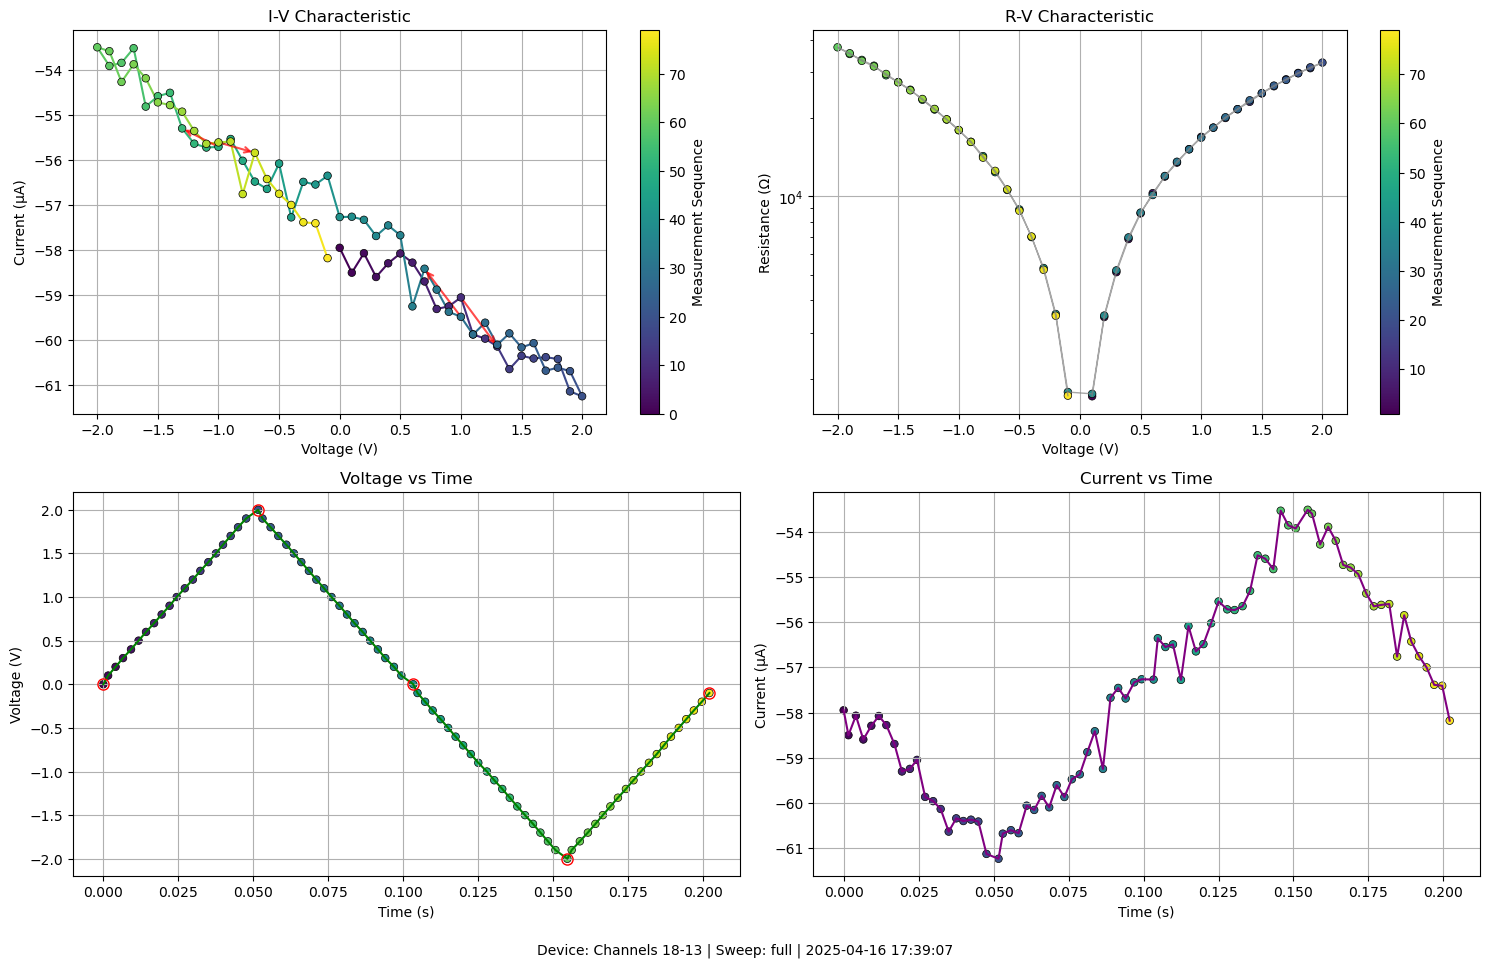

Data exported to /scratch/renj/ArcTwo Code/iv_meas_full_ch18-13_20250416_174005.h5


In [ ]:
from pyarc2 import Instrument, find_ids, DataMode, ReadType, ReadAt, ReadAfter
import numpy as np
import matplotlib.pyplot as plt
import traceback
import time
from datetime import datetime
import h5py
import os

def detailed_device_check(arc2, low_chan, high_chan):
    """
    Perform a detailed diagnostic check on the device channels
    """
    print("\n--- Detailed Device Channel Diagnostics ---")
    
    try:
        # Reset all channels
        print("Resetting all channels to ground...")
        arc2.ground_all().execute()
        
        # Check basic voltage reading
        print("\nTesting voltage read capabilities:")
        try:
            # Try reading voltage on the specified channels
            voltage_readings = arc2.vread_channels([low_chan, high_chan], averaging=True)
            print(f"Voltage readings: {voltage_readings}")
        except Exception as e:
            print(f"Error reading voltages: {e}")
        
        # Try a simple pulse
        print("\nTesting basic pulse operation:")
        try:
            # Apply a small pulse and read
            arc2.pulse_one(low_chan, high_chan, 0.5, 1000).execute()
            
            # Attempt to read current
            try:
                current = arc2.read_one(low_chan, high_chan, 0.2)
                print(f"Read current after pulse: {current}")
            except Exception as curr_err:
                print(f"Error reading current: {curr_err}")
        except Exception as pulse_err:
            print(f"Error applying pulse: {pulse_err}")
        
        # Verify channel configuration
        print("\nVerifying channel configuration:")
        try:
            # Configure channels to arbitrary voltage mode
            arc2.config_channels([(low_chan, 0.1), (high_chan, 0.1)], None).execute()
            print("Channels configured successfully")
        except Exception as config_err:
            print(f"Error configuring channels: {config_err}")
    
    except Exception as e:
        print(f"Unexpected error in device check: {e}")

def memristor_iv_sweep(device_id, firmware_path, low_chan, high_chan, voltage_range=(-2.0, 2.0), steps=21, 
                   sweep_type='full', reset_voltage=None, compliance_current=1e-3, debug=False):
    """
    Perform a comprehensive IV sweep with proper memristor characterization using generate_ramp
    
    Parameters:
    -----------
    device_id : int
        ArC TWO device ID
    firmware_path : str
        Path to firmware file
    low_chan : int
        Low potential channel
    high_chan : int
        High potential channel
    voltage_range : tuple
        (min_voltage, max_voltage)
    steps : int
        Number of voltage steps in one direction
    sweep_type : str
        Type of sweep pattern: 
        - 'full': 0 → max → 0 → min → 0 (complete memristor characterization)
        - 'hysteresis': min → max → min (standard hysteresis)
        - 'bipolar': min → 0 → max → 0 → min
    reset_voltage : float or None
        Optional voltage to reset the device state before starting sweep
    debug : bool
        Enable verbose debug output
    
    Returns:
    --------
    dict
        Dictionary containing measurement results
    """
    from pyarc2 import Instrument, ReadAt, ReadAfter, DataMode, IdleMode
    import numpy as np
    import time
    from datetime import datetime
    
    print("\n--- Starting Enhanced IV Sweep Using generate_ramp ---")
    
    # Open instrument
    try:
        print("Opening instrument...")
        arc2 = Instrument(device_id, firmware_path)
        print("Instrument opened successfully")
    except Exception as e:
        print(f"Error opening instrument: {e}")
        print(traceback.format_exc())
        return None

    # Run detailed check if in debug mode
    if debug:
        detailed_device_check(arc2, low_chan, high_chan)

    # Create voltage sweep based on specified pattern
    min_v, max_v = voltage_range
    
    # Define ramp segments based on sweep_type
    ramp_segments = []
    
    if sweep_type == 'full':
        # Full characterization cycle: 0 → max → 0 → min → 0
        ramp_segments.append((0, max_v))      # 0 → max
        ramp_segments.append((max_v, 0))      # max → 0
        ramp_segments.append((0, min_v))      # 0 → min
        ramp_segments.append((min_v, 0))      # min → 0
        
    elif sweep_type == 'hysteresis':
        # Traditional hysteresis loop: min → max → min
        ramp_segments.append((min_v, max_v))  # min → max
        ramp_segments.append((max_v, min_v))  # max → min
        
    elif sweep_type == 'bipolar':
        # Bipolar sweep: min → 0 → max → 0 → min
        ramp_segments.append((min_v, 0))      # min → 0
        ramp_segments.append((0, max_v))      # 0 → max
        ramp_segments.append((max_v, 0))      # max → 0
        ramp_segments.append((0, min_v))      # 0 → min
    
    else:
        print(f"Unknown sweep type '{sweep_type}'. Using default hysteresis pattern.")
        ramp_segments.append((min_v, max_v))  # min → max
        ramp_segments.append((max_v, min_v))  # max → min
    
    # Result containers
    voltages = []
    currents = []
    resistances = []
    timestamps = []
    
    try:
        # Reset and ground
        print("\n--- Starting IV Sweep Measurement ---")
        arc2.ground_all().execute()
        
        # Apply reset voltage if specified (for consistent initial state)
        if reset_voltage is not None:
            print(f"Applying reset voltage: {reset_voltage} V")
            try:
                if reset_voltage >= 0:
                    arc2.pulse_one(low_chan, high_chan, reset_voltage, 100000).execute()  # 100ms pulse
                else:
                    arc2.pulse_one(high_chan, low_chan, abs(reset_voltage), 100000).execute()
                # Wait for stabilization
                time.sleep(0.1)
                arc2.ground_all().execute()
                time.sleep(0.1)
            except Exception as reset_error:
                print(f"Error applying reset voltage: {reset_error}")
        
        # Process each ramp segment
        print(f"Starting sweep using {sweep_type} pattern with {len(ramp_segments)} segments")
        
        for segment_idx, (v_start, v_stop) in enumerate(ramp_segments):
            print(f"Processing segment {segment_idx+1}/{len(ramp_segments)}: {v_start}V → {v_stop}V")
            
            # Calculate step size
            v_step = (v_stop - v_start) / (steps - 1) if steps > 1 else 0
            
            # Configure pulse parameters
            pulse_width = 100000        # 100μs pulse width
            inter_pulse_delay = 1000000  # 1ms between pulses
            num_pulses = 1              # 1 pulse per voltage step
            
            # Generate and execute the ramp
            arc2.generate_ramp(
                low_chan, high_chan,
                v_start, v_step, v_stop,
                pulse_width, inter_pulse_delay, num_pulses,
                ReadAt.Bias, ReadAfter.Pulse
            ).execute()
            # arc2.finalise_operation(IdleMode.SoftGnd)
            # arc2.wait()
            
            # Collect results using get_iter - using DataMode.All to get all channel currents
            segment_start_time = time.time()
            segment_voltages = np.linspace(v_start, v_stop, steps)
            
            for idx, current_data in enumerate(arc2.get_iter(DataMode.Bits)):
                # Record timestamp
                curr_timestamp = time.time()
                timestamps.append(curr_timestamp)
                
                # Get the current voltage point
                if idx < len(segment_voltages):
                    voltage = segment_voltages[idx]
                    voltages.append(voltage)
                    
                    # Extract current value for the high channel
                    current = current_data[0][high_chan]
                    currents.append(current)
                    
                    # Calculate resistance
                    resistance = voltage / current if abs(current) > 1e-12 else float('inf')
                    resistances.append(resistance)
                    
                    if debug:
                        print(f"V={voltage:.3f}V, I={current:.3e}A, R={resistance:.2e}Ω")
                    
                    # Check for 

                    
                    if abs(current) > compliance_current:
                        print(f"Compliance current exceeded ({abs(current):.3e} A > {compliance_current:.3e} A). Stopping sweep.")
                        break  # Stop the sweep if compliance is exceeded
                
            # Small delay between segments
            # time.sleep(0.1)
        
    except Exception as e:
        print(f"Unexpected error during IV sweep: {e}")
        print(traceback.format_exc())
        return None
    
    finally:
        # Ensure device is grounded after measurement
        try:
            arc2.ground_all().execute()
            print("Device grounded after measurement")
        except Exception as ground_error:
            print(f"Error grounding device: {ground_error}")
    
    # Prepare results dictionary
    results = {
        'voltage': np.array(voltages),
        'current': np.array(currents),
        'resistance': np.array(resistances),
        'timestamp': np.array(timestamps),
        'low_chan': int(low_chan),
        'high_chan': int(high_chan),
        'sweep_type': sweep_type,
        'voltage_range': voltage_range,
        'measurement_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    return results

def plot_iv_curves(results, save_plot=False):
    """
    Plot comprehensive I-V curve analysis with multiple perspectives
    
    Parameters:
    -----------
    results : dict
        Dictionary containing measurement results
    save_plot : bool
        Whether to save the plot to file
    """
    if results is None:
        print("No valid data to plot")
        return
    
    try:
        # Create figure with subplots
        fig = plt.figure(figsize=(15, 10))
        
        # 1. I-V Characteristic curve
        ax1 = fig.add_subplot(2, 2, 1)
        
        # Use color gradient to show measurement sequence
        voltage = results['voltage']
        current = np.array(results['current']) * 1e6  # Convert to μA
        n_points = len(voltage)
        
        # Create a color gradient to show the sequence
        colors = plt.cm.viridis(np.linspace(0, 1, n_points))
        
        # Plot points with color gradient and connect with lines
        for i in range(n_points-1):
            ax1.plot(voltage[i:i+2], current[i:i+2], '-', color=colors[i], linewidth=1.5)
        
        # Plot scatter points on top
        scatter = ax1.scatter(voltage, current, c=np.arange(n_points), cmap='viridis', 
                              s=30, zorder=10, edgecolor='black', linewidth=0.5)
        
        # Add colorbar to show sequence direction
        cbar = plt.colorbar(scatter, ax=ax1)
        cbar.set_label('Measurement Sequence')
        
        # Add arrows to show sweep direction at key points
        arrow_indices = []
        # Choose arrow positions based on sweep type
        if 'sweep_type' in results and results['sweep_type'] == 'full':
            # For the full cycle, place arrows at key transitions
            steps_per_segment = n_points // 4
            arrow_indices = [steps_per_segment//2, steps_per_segment+steps_per_segment//2, 
                            2*steps_per_segment+steps_per_segment//2, 3*steps_per_segment+steps_per_segment//2]
        else:
            # Default approach for other sweep types
            arrow_indices = [int(n_points/8), int(3*n_points/8), int(5*n_points/8), int(7*n_points/8)]
        
        for i in arrow_indices:
            if i+3 < n_points:
                ax1.annotate('',
                            xy=(voltage[i+3], current[i+3]),
                            xytext=(voltage[i], current[i]),
                            arrowprops=dict(arrowstyle='->', lw=1.5, color='red', alpha=0.7))
        
        ax1.set_xlabel('Voltage (V)')
        ax1.set_ylabel('Current (μA)')
        ax1.set_title('I-V Characteristic')
        ax1.grid(True)
        
        # 2. R-V Characteristic curve (log scale)
        ax2 = fig.add_subplot(2, 2, 2)
        resistance_data = np.array(results['resistance'])
        # Convert to absolute values before filtering
        abs_resistance = np.abs(resistance_data)
        # Filter out non-finite or very large values
        valid_indices = np.isfinite(abs_resistance) & (abs_resistance > 0) & (abs_resistance < 1e9)

        if np.any(valid_indices):
            scatter_r = ax2.scatter(
                np.array(voltage)[valid_indices],
                abs_resistance[valid_indices],  # Already absolute values
                c=np.arange(n_points)[valid_indices],
                cmap='viridis',
                s=30,
                edgecolor='black',
                linewidth=0.5
            )
            
            # Connect points with lines
            ax2.semilogy(
                np.array(voltage)[valid_indices],
                abs_resistance[valid_indices],  # Already absolute values
                '-',
                linewidth=1,
                alpha=0.7,
                color='gray'
            )
            # Add colorbar
            cbar_r = plt.colorbar(scatter_r, ax=ax2)
            cbar_r.set_label('Measurement Sequence')
            
        ax2.set_xlabel('Voltage (V)')
        ax2.set_ylabel('Resistance (Ω)')
        ax2.set_title('R-V Characteristic')
        ax2.grid(True)
        
        # Create relative time axis in seconds
        time_values = np.array(results['timestamp']) - results['timestamp'][0]
        
        # 3. Voltage vs Time plot
        ax3 = fig.add_subplot(2, 2, 3)
        ax3.plot(time_values, voltage, '-', linewidth=1.5, color='green')
        ax3.scatter(time_values, voltage, c=np.arange(n_points), cmap='viridis', 
                   s=30, edgecolor='black', linewidth=0.5)
        
        # Mark important transitions in the voltage pattern
        if 'sweep_type' in results:
            sweep_type = results['sweep_type']
            if sweep_type == 'full' or sweep_type == 'set-reset':
                # Mark the 0→max→0→min→0 transitions
                segments = n_points // 4
                transition_points = [0, segments, 2*segments, 3*segments, n_points-1]
                for idx in transition_points:
                    ax3.plot(time_values[idx], voltage[idx], 'ro', markersize=8, fillstyle='none')
        
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Voltage (V)')
        ax3.set_title('Voltage vs Time')
        ax3.grid(True)
        
        # 4. Current vs Time plot
        ax4 = fig.add_subplot(2, 2, 4)
        ax4.plot(time_values, current, '-', linewidth=1.5, color='purple')
        scatter_i = ax4.scatter(time_values, current, c=np.arange(n_points), cmap='viridis', 
                              s=30, edgecolor='black', linewidth=0.5)
        
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Current (μA)')
        ax4.set_title('Current vs Time')
        ax4.grid(True)
        
        # Add metadata as text annotation
        plt.figtext(0.5, 0.01, 
                  f"Device: Channels {results['low_chan']}-{results['high_chan']} | " +
                  f"Sweep: {results.get('sweep_type', 'standard')} | " +
                  f"{results['measurement_time']}", 
                  ha='center', fontsize=10)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        
        if save_plot:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f'iv_curve_analysis_{timestamp}.png'
            plt.savefig(filename, dpi=300)
            print(f"Plot saved to {filename}")
        
        plt.show()
        
    except Exception as e:
        print(f"Error plotting characteristics: {e}")
        print(traceback.format_exc())

def export_data_h5(results, filename=None, export_path=None, compression="gzip"):
    """
    Export measurement data to HDF5 (H5) file.
    Stores primary data arrays as datasets and scalar metadata as attributes.
    """
    if results is None:
        print("No data to export")
        return

    try:
        # Generate filename if not provided
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            sweep_type = results.get('sweep_type', 'sweep')
            low_ch = results.get('low_chan', 'L')
            high_ch = results.get('high_chan', 'H')
            filename = f'iv_meas_{sweep_type}_ch{low_ch}-{high_ch}_{timestamp}.h5'

        # Determine export path
        if export_path is None:
            export_path = os.getcwd()  # Use current working directory if not specified

        # Create directory if it doesn't exist
        os.makedirs(export_path, exist_ok=True)

        # Create full file path
        full_path = os.path.join(export_path, filename)

        # Create H5 file
        with h5py.File(full_path, 'w') as hf:
            # --- Store Primary Data Arrays as Datasets ---
            compression_opts = compression if compression else None

            if 'voltage' in results and results['voltage'] is not None:
                 hf.create_dataset('voltage', data=results['voltage'], compression=compression_opts)
            if 'current' in results and results['current'] is not None:
                 hf.create_dataset('current', data=results['current'], compression=compression_opts)
            if 'resistance' in results and results['resistance'] is not None:
                 hf.create_dataset('resistance', data=results['resistance'], compression=compression_opts)
            if 'timestamp' in results and results['timestamp'] is not None:
                 # Store relative time in seconds
                 hf.create_dataset('timestamp_relative_s', data=results['timestamp'] - results['timestamp'][0], compression=compression_opts)

            # --- Store Scalar Metadata as Attributes ---
            metadata_to_store = {}
            for k, v in results.items():
                # Include items that are not numpy arrays (or specific arrays like voltage_range)
                if not isinstance(v, np.ndarray) or k in ['voltage_range']:
                     metadata_to_store[k] = v

            # Add metadata as attributes to the root group
            for k, v in metadata_to_store.items():
                try:
                    # Attempt to store directly
                    hf.attrs[k] = v
                except TypeError:
                    # If direct storage fails (e.g., for tuples or complex objects), store as string
                    hf.attrs[k] = str(v) # Fallback to string representation

            # Optionally add the source script name
            hf.attrs['source_script'] = 'newIV.ipynb'


        print(f"Data exported to {full_path}")

    except Exception as e:
        print(f"Error exporting data: {e}")
        print(traceback.format_exc())


def main():
    try:
        # Find available devices
        print("Discovering devices...")
        ids = find_ids()
        
        if len(ids) == 0:
            print('No ArC2 devices found')
            return
        
        # Device configuration (adjust as needed)
        device_id = ids[0]
        firmware_path = '/home/abaigol/.local/share/arc2control/firmware/efm03_20240918.bin'
        low_chan = 18   # Update with your device channels
        high_chan = 13
        
        print(f"Using device ID: {device_id}")
        
        # Provide a menu of available sweep types
        print("\nAvailable Sweep Types:")
        print("1. Full (0 → max → 0 → min → 0) - Complete memristor characterization")
        print("2. Hysteresis (min → max → min) - Standard hysteresis")
        # print("3. SET-RESET (0 → max → 0 → min → 0) - Bipolar switching pattern")
        print("3. Bipolar (min → 0 → max → 0 → min) - Full bipolar cycle")
        
        sweep_choice = input("Choose sweep type (1-3) [default=1]: ")
        
        sweep_type_map = {
            '1': 'full',
            '2': 'hysteresis',
            '3': 'bipolar'
        }
        
        sweep_type = sweep_type_map.get(sweep_choice.strip(), 'full')
        
        # Ask for voltage range
        try:
            min_v = float(input(f"Enter minimum voltage (V) [default=-2.0]: ") or "-2.0")
            max_v = float(input(f"Enter maximum voltage (V) [default=2.0]: ") or "2.0")
            steps = int(input(f"Enter number of steps per segment [default=21]: ") or "21")
        except ValueError:
            print("Invalid input. Using default values.")
            min_v, max_v, steps = -2.0, 2.0, 21
            
        # Ask about reset pulse
        try:
            reset_choice = input("Apply reset pulse before measurement? (y/n) [default=n]: ").strip().lower()
            if reset_choice == 'y':
                reset_v = float(input("Enter reset voltage (V): "))
            else:
                reset_v = None
        except ValueError:
            print("Invalid input. No reset pulse will be applied.")
            reset_v = None
        
        # Perform enhanced IV sweep
        results = memristor_iv_sweep(
            device_id, 
            firmware_path, 
            low_chan, 
            high_chan,
            voltage_range=(min_v, max_v),
            steps=steps,
            sweep_type=sweep_type,
            reset_voltage=reset_v,
            debug=True
        )
        
        # Plot and export results
        if results is not None:
            plot_iv_curves(results, save_plot=False)
            # Ask about data export
            export_choice = input("Export measurement data to H5? (y/n) [default=y]: ").strip().lower()
            if export_choice != 'n':
                export_data_h5(results) #Use the H5 export function.
        else:
            print("No valid data to analyze")
    
    except Exception as e:
        print(f"Unexpected error in main: {e}")
        print(traceback.format_exc())

if __name__ == '__main__':
    main()

In [1]:
from pyarc2 import Instrument, ReadAt, ReadAfter, DataMode, IdleMode, find_ids, BiasOrder
import numpy as np

ids = find_ids()
print(ids)

if len(ids) == 0:
    print('no arc2')
    
# fw.bin is the firmware to load on ArC TWO
arc = Instrument(ids[0], '/home/abaigol/.local/share/arc2control/firmware/efm03_20240918.bin')

arc.generate_ramp(13, 18, 0.0, 0.1, 1.0, 100, 10_00, 1, ReadAt.Bias, ReadAfter.Pulse).execute()
arc.finalise_operation(IdleMode.SoftGnd)
arc.wait()

data = arc.get_iter(DataMode.All)

for datum in data:

    print(datum[0]) # 32-element array containing bitline currents

[0]
[          nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan 2.4830987e-07           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan]
[          nan           nan           nan           nan           nan
           nan 

# using config_channel into read_slice_open_deferred -> gapless

Discovering devices...
Using device ID: 0

Available Sweep Types:
1. Full (0 → max → 0 → min → 0) - Complete memristor characterization
2. Hysteresis (min → max → min) - Standard hysteresis
3. Bipolar (min → 0 → max → 0 → min) - Full bipolar cycle

--- Starting Enhanced IV Sweep Using Gapless Staircase Method ---
Opening instrument...
Instrument opened successfully

--- Detailed Device Channel Diagnostics ---
Resetting all channels to ground...

Testing voltage read capabilities:
Voltage readings: [0.002890625037252903, -0.0021875000093132257]

Testing basic pulse operation:
Read current after pulse: -5.7174005632987246e-05

Verifying channel configuration:
Channels configured successfully

--- Starting IV Sweep Measurement ---
Starting sweep using full pattern with 4 segments
Processing segment 1/4: 0.000V → 2.000V
V=0.000V, I=-5.659e-05A, R=-0.00e+00Ω
V=0.100V, I=-5.678e-05A, R=-1.76e+03Ω
V=0.200V, I=-5.704e-05A, R=-3.51e+03Ω
V=0.300V, I=-5.704e-05A, R=-5.26e+03Ω
V=0.400V, I=-5.721e-

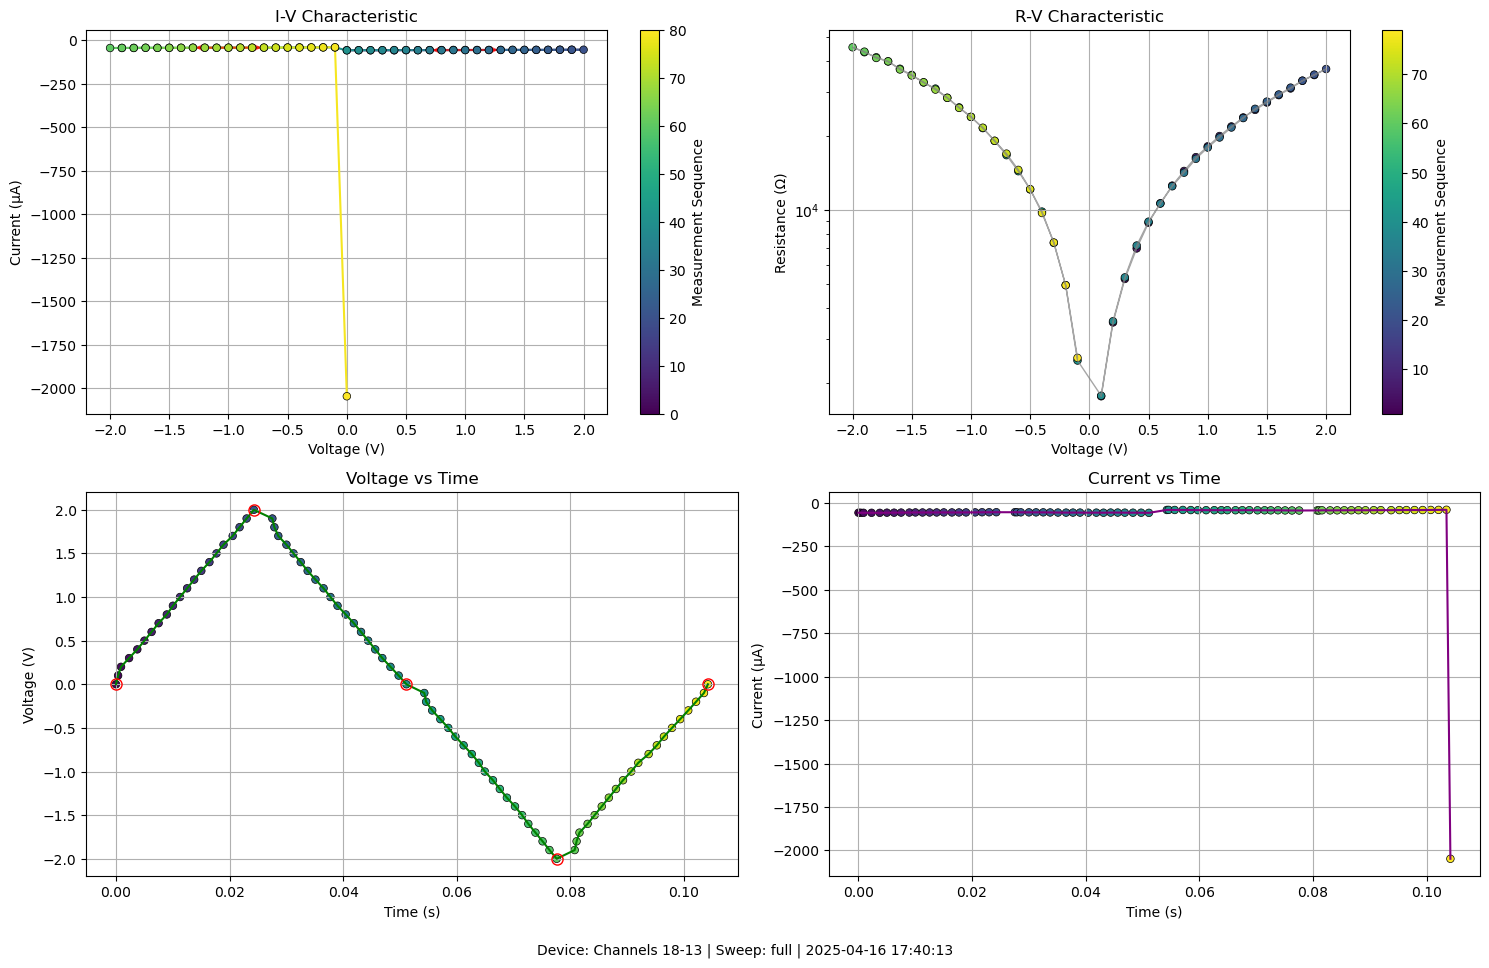

Data exported to /scratch/renj/ArcTwo Code/iv_meas_full_ch18-13_20250416_174021.h5


In [ ]:
from pyarc2 import Instrument, find_ids, DataMode, ReadType, ReadAt, ReadAfter
import numpy as np
import matplotlib.pyplot as plt
import traceback
import time
from datetime import datetime
import h5py
import os

def detailed_device_check(arc2, low_chan, high_chan):
    """
    Perform a detailed diagnostic check on the device channels
    """
    print("\n--- Detailed Device Channel Diagnostics ---")
    
    try:
        # Reset all channels
        print("Resetting all channels to ground...")
        arc2.ground_all().execute()
        
        # Check basic voltage reading
        print("\nTesting voltage read capabilities:")
        try:
            # Try reading voltage on the specified channels
            voltage_readings = arc2.vread_channels([low_chan, high_chan], averaging=True)
            print(f"Voltage readings: {voltage_readings}")
        except Exception as e:
            print(f"Error reading voltages: {e}")
        
        # Try a simple pulse
        print("\nTesting basic pulse operation:")
        try:
            # Apply a small pulse and read
            arc2.pulse_one(low_chan, high_chan, 0.5, 1000).execute()
            # Attempt to read current
            try:
                current = arc2.read_one(low_chan, high_chan, 0.2)
                print(f"Read current after pulse: {current}")
            except Exception as curr_err:
                print(f"Error reading current: {curr_err}")
        except Exception as pulse_err:
            print(f"Error applying pulse: {pulse_err}")
        
        # Verify channel configuration
        print("\nVerifying channel configuration:")
        try:
            # Configure channels to arbitrary voltage mode
            arc2.config_channels([(low_chan, 0.1), (high_chan, 0.1)], None).execute()
            print("Channels configured successfully")
        except Exception as config_err:
            print(f"Error configuring channels: {config_err}")
    
    except Exception as e:
        print(f"Unexpected error in device check: {e}")

def memristor_iv_sweep_gapless(device_id, firmware_path, low_chan, high_chan, voltage_range=(-2.0, 2.0), steps=21, 
                            sweep_type='full', reset_voltage=None, read_delay_ns=1000, compliance_current=1e-1, debug=False):
    """
    Perform a comprehensive IV sweep with proper memristor characterization using gapless staircase measurements.
    
    Parameters:
    -----------
    device_id : int
        ArC TWO device ID
    firmware_path : str
        Path to firmware file
    low_chan : int
        Low potential channel
    high_chan : int
        High potential channel
    voltage_range : tuple
        (min_voltage, max_voltage)
    steps : int
        Number of voltage steps in one direction
    sweep_type : str
        Type of sweep pattern: 
        - 'full': 0 → max → 0 → min → 0 (complete memristor characterization)
        - 'hysteresis': min → max → min (standard hysteresis)
        - 'bipolar': min → 0 → max → 0 → min
    reset_voltage : float or None
        Optional voltage to reset the device state before starting sweep
    read_delay_ns : int
        Minimum delay between reads in nanoseconds for stability
    compliance_current : float
        Maximum current allowed during operation
    debug : bool
        Enable verbose debug output
    
    Returns:
    --------
    dict
        Dictionary containing measurement results
    """
    from pyarc2 import Instrument, DataMode, ReadType
    import numpy as np
    import time
    from datetime import datetime
    
    print("\n--- Starting Enhanced IV Sweep Using Gapless Staircase Method ---")
    
    # Open instrument
    try:
        print("Opening instrument...")
        arc2 = Instrument(device_id, firmware_path)
        print("Instrument opened successfully")
    except Exception as e:
        print(f"Error opening instrument: {e}")
        print(traceback.format_exc())
        return None

    # Run detailed check if in debug mode
    if debug:
        detailed_device_check(arc2, low_chan, high_chan)

    # Create voltage sweep based on specified pattern
    min_v, max_v = voltage_range
    
    # Define segment sequences based on sweep_type
    segments = []
    
    if sweep_type == 'full':
        # Full characterization cycle: 0 → max → 0 → min → 0
        segments.append(np.linspace(0, max_v, steps))      # 0 → max
        segments.append(np.linspace(max_v, 0, steps)[1:])      # max → 0
        segments.append(np.linspace(0, min_v, steps)[1:])      # 0 → min
        segments.append(np.linspace(min_v, 0, steps)[1:])      # min → 0
        
    elif sweep_type == 'hysteresis':
        # Traditional hysteresis loop: min → max → min
        segments.append(np.linspace(min_v, max_v, steps))  # min → max
        segments.append(np.linspace(max_v, min_v, steps)[1:])  # max → min
        
    elif sweep_type == 'bipolar':
        # Bipolar sweep: min → 0 → max → 0 → min
        segments.append(np.linspace(min_v, 0, steps))      # min → 0
        segments.append(np.linspace(0, max_v, steps)[1:])      # 0 → max
        segments.append(np.linspace(max_v, 0, steps)[1:])      # max → 0
        segments.append(np.linspace(0, min_v, steps)[1:])      # 0 → min
    
    else:
        print(f"Unknown sweep type '{sweep_type}'. Using default full pattern.")
        segments.append(np.linspace(0, max_v, steps))      # 0 → max
        segments.append(np.linspace(max_v, 0, steps)[1:])      # max → 0
        segments.append(np.linspace(0, min_v, steps)[1:])      # 0 → min
        segments.append(np.linspace(min_v, 0, steps)[1:])      # min → 0
    
    # Result containers
    voltages = []
    currents = []
    resistances = []
    timestamps = []
    
    try:
        # Reset and ground
        print("\n--- Starting IV Sweep Measurement ---")
        arc2.ground_all().execute()
        
        # Apply reset voltage if specified (for consistent initial state)
        if reset_voltage is not None:
            print(f"Applying reset voltage: {reset_voltage} V")
            try:
                if reset_voltage >= 0:
                    arc2.pulse_one(low_chan, high_chan, reset_voltage, 100000).execute()  # 100ms pulse
                else:
                    arc2.pulse_one(high_chan, low_chan, abs(reset_voltage), 100000).execute()
                # Wait for stabilization
                time.sleep(0.1)
                arc2.ground_all().execute()
                time.sleep(0.1)
            except Exception as reset_error:
                print(f"Error applying reset voltage: {reset_error}")
        
        # Process each segment with gapless staircase method
        print(f"Starting sweep using {sweep_type} pattern with {len(segments)} segments")
        
        for segment_idx, segment_voltages in enumerate(segments):
            print(f"Processing segment {segment_idx+1}/{len(segments)}: {segment_voltages[0]:.3f}V → {segment_voltages[-1]:.3f}V")
            
            start_time = time.time()
            
            # Queue all operations without intermediate grounding for this segment
            for v in segment_voltages:
                # Configure channels for the voltage (direction depends on sign)
                if v >= 0:
                    arc2.config_channels([(low_chan, v)], None)
                    arc2.read_slice_open_deferred([high_chan], True)
                else:
                    arc2.config_channels([(high_chan, -v)], None)
                    arc2.read_slice_open_deferred([low_chan], True)
                
                # # Read current immediately without grounding
                # arc2.read_slice_open_deferred([high_chan], True)
                
                # Optional tiny delay between reads if needed for stability
                # if read_delay_ns > 0:
                #     arc2.delay(read_delay_ns)
            
            # Execute the batched commands for this segment
            arc2.execute()
 
            # Use get_iter to retrieve results - more reliable than pick_one
            for idx, data in enumerate(arc2.get_iter(DataMode.All)):
                if idx < len(segment_voltages):
                    voltages.append(segment_voltages[idx])
                    
                    curr_timestamp = time.time()
                    timestamps.append(curr_timestamp)

                    # Get current for the appropriate channel
                    if segment_voltages[idx] >= 0:
                        current = data[0][high_chan]  # Current on high channel for positive voltage
                    else:
                        current = -data[0][low_chan]  # Current on low channel for negative voltage (invert sign)
                        
                    currents.append(current)

                                # Calculate resistance
                    if abs(current) > 1e-12:
                        resistance = segment_voltages[idx] / current 
                    else:
                        resistance = float('inf')
                    resistances.append(resistance)
            
                    if debug:
                        print(f"V={segment_voltages[idx]:.3f}V, I={current:.3e}A, R={voltages[idx]/current:.2e}Ω")
                    
                    # Check for compliance
                    if abs(current) > compliance_current:
                        print(f"Compliance current exceeded ({abs(current):.3e} A > {compliance_current:.3e} A). Stopping segment.")
                        break
            
            if debug:
                segment_time = time.time() - start_time
                print(f"Segment {segment_idx+1} completed in {segment_time:.3f}s")
                
        
    except Exception as e:
        print(f"Unexpected error during IV sweep: {e}")
        print(traceback.format_exc())
        return None
    
    finally:
        # Ensure device is grounded after measurement
        try:
            arc2.ground_all().execute()
            print("Device grounded after measurement")
        except Exception as ground_error:
            print(f"Error grounding device: {ground_error}")
    
    # Prepare results dictionary
    results = {
        'voltage': np.array(voltages),
        'current': np.array(currents),
        'resistance': np.array(resistances),
        'timestamp': np.array(timestamps),
        'low_chan': int(low_chan),
        'high_chan': int(high_chan),
        'sweep_type': sweep_type,
        'voltage_range': voltage_range,
        'measurement_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    return results
def plot_iv_curves(results, save_plot=False):
    """
    Plot comprehensive I-V curve analysis with multiple perspectives
    
    Parameters:
    -----------
    results : dict
        Dictionary containing measurement results
    save_plot : bool
        Whether to save the plot to file
    """
    if results is None:
        print("No valid data to plot")
        return
    
    try:
        # Create figure with subplots
        fig = plt.figure(figsize=(15, 10))
        
        # 1. I-V Characteristic curve
        ax1 = fig.add_subplot(2, 2, 1)
        
        # Use color gradient to show measurement sequence
        voltage = results['voltage']
        current = np.array(results['current']) * 1e6  # Convert to μA
        n_points = len(voltage)
        
        # Create a color gradient to show the sequence
        colors = plt.cm.viridis(np.linspace(0, 1, n_points))
        
        # Plot points with color gradient and connect with lines
        for i in range(n_points-1):
            ax1.plot(voltage[i:i+2], current[i:i+2], '-', color=colors[i], linewidth=1.5)
        
        # Plot scatter points on top
        scatter = ax1.scatter(voltage, current, c=np.arange(n_points), cmap='viridis', 
                              s=30, zorder=10, edgecolor='black', linewidth=0.5)
        
        # Add colorbar to show sequence direction
        cbar = plt.colorbar(scatter, ax=ax1)
        cbar.set_label('Measurement Sequence')
        
        # Add arrows to show sweep direction at key points
        arrow_indices = []
        # Choose arrow positions based on sweep type
        if 'sweep_type' in results and results['sweep_type'] == 'full':
            # For the full cycle, place arrows at key transitions
            steps_per_segment = n_points // 4
            arrow_indices = [steps_per_segment//2, steps_per_segment+steps_per_segment//2, 
                            2*steps_per_segment+steps_per_segment//2, 3*steps_per_segment+steps_per_segment//2]
        else:
            # Default approach for other sweep types
            arrow_indices = [int(n_points/8), int(3*n_points/8), int(5*n_points/8), int(7*n_points/8)]
        
        for i in arrow_indices:
            if i+3 < n_points:
                ax1.annotate('',
                            xy=(voltage[i+3], current[i+3]),
                            xytext=(voltage[i], current[i]),
                            arrowprops=dict(arrowstyle='->', lw=1.5, color='red', alpha=0.7))
        
        ax1.set_xlabel('Voltage (V)')
        ax1.set_ylabel('Current (μA)')
        ax1.set_title('I-V Characteristic')
        ax1.grid(True)
        
        # 2. R-V Characteristic curve (log scale)
        ax2 = fig.add_subplot(2, 2, 2)
        resistance_data = np.array(results['resistance'])
        # Convert to absolute values before filtering
        abs_resistance = np.abs(resistance_data)
        # Filter out non-finite or very large values
        valid_indices = np.isfinite(abs_resistance) & (abs_resistance > 0) & (abs_resistance < 1e9)

        if np.any(valid_indices):
            scatter_r = ax2.scatter(
                np.array(voltage)[valid_indices],
                abs_resistance[valid_indices],  # Already absolute values
                c=np.arange(n_points)[valid_indices],
                cmap='viridis',
                s=30,
                edgecolor='black',
                linewidth=0.5
            )
            
            # Connect points with lines
            ax2.semilogy(
                np.array(voltage)[valid_indices],
                abs_resistance[valid_indices],  # Already absolute values
                '-',
                linewidth=1,
                alpha=0.7,
                color='gray'
            )
            # Add colorbar
            cbar_r = plt.colorbar(scatter_r, ax=ax2)
            cbar_r.set_label('Measurement Sequence')
            
        ax2.set_xlabel('Voltage (V)')
        ax2.set_ylabel('Resistance (Ω)')
        ax2.set_title('R-V Characteristic')
        ax2.grid(True)
        
        # Create relative time axis in seconds
        time_values = np.array(results['timestamp']) - results['timestamp'][0]
        
        # 3. Voltage vs Time plot
        ax3 = fig.add_subplot(2, 2, 3)
        ax3.plot(time_values, voltage, '-', linewidth=1.5, color='green')
        ax3.scatter(time_values, voltage, c=np.arange(n_points), cmap='viridis', 
                   s=30, edgecolor='black', linewidth=0.5)
        
        # Mark important transitions in the voltage pattern
        if 'sweep_type' in results:
            sweep_type = results['sweep_type']
            if sweep_type == 'full' or sweep_type == 'set-reset':
                # Mark the 0→max→0→min→0 transitions
                segments = n_points // 4
                transition_points = [0, segments, 2*segments, 3*segments, n_points-1]
                for idx in transition_points:
                    ax3.plot(time_values[idx], voltage[idx], 'ro', markersize=8, fillstyle='none')
        
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Voltage (V)')
        ax3.set_title('Voltage vs Time')
        ax3.grid(True)
        
        # 4. Current vs Time plot
        ax4 = fig.add_subplot(2, 2, 4)
        ax4.plot(time_values, current, '-', linewidth=1.5, color='purple')
        scatter_i = ax4.scatter(time_values, current, c=np.arange(n_points), cmap='viridis', 
                              s=30, edgecolor='black', linewidth=0.5)
        
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Current (μA)')
        ax4.set_title('Current vs Time')
        ax4.grid(True)
        
        # Add metadata as text annotation
        plt.figtext(0.5, 0.01, 
                  f"Device: Channels {results['low_chan']}-{results['high_chan']} | " +
                  f"Sweep: {results.get('sweep_type', 'standard')} | " +
                  f"{results['measurement_time']}", 
                  ha='center', fontsize=10)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        
        if save_plot:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f'iv_curve_analysis_{timestamp}.png'
            plt.savefig(filename, dpi=300)
            print(f"Plot saved to {filename}")
        
        plt.show()
        
    except Exception as e:
        print(f"Error plotting characteristics: {e}")
        print(traceback.format_exc())

def export_data_h5(results, filename=None, export_path=None, compression="gzip"):
    """
    Export measurement data to HDF5 (H5) file.
    Stores primary data arrays as datasets and scalar metadata as attributes.
    """
    if results is None:
        print("No data to export")
        return

    try:
        # Generate filename if not provided
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            sweep_type = results.get('sweep_type', 'sweep')
            low_ch = results.get('low_chan', 'L')
            high_ch = results.get('high_chan', 'H')
            filename = f'iv_meas_{sweep_type}_ch{low_ch}-{high_ch}_{timestamp}.h5'

        # Determine export path
        if export_path is None:
            export_path = os.getcwd()  # Use current working directory if not specified

        # Create directory if it doesn't exist
        os.makedirs(export_path, exist_ok=True)

        # Create full file path
        full_path = os.path.join(export_path, filename)

        # Create H5 file
        with h5py.File(full_path, 'w') as hf:
            # --- Store Primary Data Arrays as Datasets ---
            compression_opts = compression if compression else None

            if 'voltage' in results and results['voltage'] is not None:
                 hf.create_dataset('voltage', data=results['voltage'], compression=compression_opts)
            if 'current' in results and results['current'] is not None:
                 hf.create_dataset('current', data=results['current'], compression=compression_opts)
            if 'resistance' in results and results['resistance'] is not None:
                 hf.create_dataset('resistance', data=results['resistance'], compression=compression_opts)
            if 'timestamp' in results and results['timestamp'] is not None:
                 # Store relative time in seconds
                 hf.create_dataset('timestamp_relative_s', data=results['timestamp'] - results['timestamp'][0], compression=compression_opts)

            # --- Store Scalar Metadata as Attributes ---
            metadata_to_store = {}
            for k, v in results.items():
                # Include items that are not numpy arrays (or specific arrays like voltage_range)
                if not isinstance(v, np.ndarray) or k in ['voltage_range']:
                     metadata_to_store[k] = v

            # Add metadata as attributes to the root group
            for k, v in metadata_to_store.items():
                try:
                    # Attempt to store directly
                    hf.attrs[k] = v
                except TypeError:
                    # If direct storage fails (e.g., for tuples or complex objects), store as string
                    hf.attrs[k] = str(v) # Fallback to string representation

            # Optionally add the source script name
            hf.attrs['source_script'] = 'newIV.ipynb'


        print(f"Data exported to {full_path}")

    except Exception as e:
        print(f"Error exporting data: {e}")
        print(traceback.format_exc())


def main():
    try:
        # Find available devices
        print("Discovering devices...")
        ids = find_ids()
        
        if len(ids) == 0:
            print('No ArC2 devices found')
            return
        
        # Device configuration (adjust as needed)
        device_id = ids[0]
        firmware_path = '/home/abaigol/.local/share/arc2control/firmware/efm03_20240918.bin'
        low_chan = 18   # Update with your device channels
        high_chan = 13
        
        print(f"Using device ID: {device_id}")
        
        # Provide a menu of available sweep types
        print("\nAvailable Sweep Types:")
        print("1. Full (0 → max → 0 → min → 0) - Complete memristor characterization")
        print("2. Hysteresis (min → max → min) - Standard hysteresis")
        # print("3. SET-RESET (0 → max → 0 → min → 0) - Bipolar switching pattern")
        print("3. Bipolar (min → 0 → max → 0 → min) - Full bipolar cycle")
        
        sweep_choice = input("Choose sweep type (1-3) [default=1]: ")
        
        sweep_type_map = {
            '1': 'full',
            '2': 'hysteresis',
            '3': 'bipolar'
        }
        
        sweep_type = sweep_type_map.get(sweep_choice.strip(), 'full')
        
        # Ask for voltage range
        try:
            min_v = float(input(f"Enter minimum voltage (V) [default=-2.0]: ") or "-2.0")
            max_v = float(input(f"Enter maximum voltage (V) [default=2.0]: ") or "2.0")
            steps = int(input(f"Enter number of steps per segment [default=21]: ") or "21")
        except ValueError:
            print("Invalid input. Using default values.")
            min_v, max_v, steps = -2.0, 2.0, 21
            
        # Ask about reset pulse
        try:
            reset_choice = input("Apply reset pulse before measurement? (y/n) [default=n]: ").strip().lower()
            if reset_choice == 'y':
                reset_v = float(input("Enter reset voltage (V): "))
            else:
                reset_v = None
        except ValueError:
            print("Invalid input. No reset pulse will be applied.")
            reset_v = None
        
        # Perform enhanced IV sweep
        results = memristor_iv_sweep_gapless(
            device_id, 
            firmware_path, 
            low_chan, 
            high_chan,
            voltage_range=(min_v, max_v),
            steps=steps,
            sweep_type=sweep_type,
            reset_voltage=reset_v,
            debug=True
        )
        
        # Plot and export results
        if results is not None:
            plot_iv_curves(results, save_plot=False)
            # Ask about data export
            export_choice = input("Export measurement data to H5? (y/n) [default=y]: ").strip().lower()
            if export_choice != 'n':
                export_data_h5(results) #Use the H5 export function.
        else:
            print("No valid data to analyze")
    
    except Exception as e:
        print(f"Unexpected error in main: {e}")
        print(traceback.format_exc())

if __name__ == '__main__':
    main()